# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle
import copy
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Load and preprocess data

In [15]:
# Define the path to the dataset
data_dir = 'C:/Users/jed95/Documents/GitHub/anomaly_detection/dataset/yahoo_s5/A2Benchmark'  # Adjust the path as necessary

# Get the list of all CSV files in the directory
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load all files into a single DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print("Data shape:", data.shape)


Data shape: (142100, 3)


In [16]:
# Check for missing values
print("Missing values:", data.isnull().sum())

# For simplicity, drop missing values (if any)
data.dropna(inplace=True)


Missing values: timestamp     0
value         0
is_anomaly    0
dtype: int64


In [17]:
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))


# Create Sequences

In [18]:
def create_sequences(values, labels, sequence_length):
    sequences = []
    seq_labels = []
    for i in range(len(values) - sequence_length + 1):
        seq = values[i:i + sequence_length]
        label = labels[i + sequence_length - 1]  # Label of the last element in the sequence
        sequences.append(seq)
        seq_labels.append(label)
    return np.array(sequences), np.array(seq_labels)

sequence_length = 10  # You can adjust this 
values = data['value'].values
labels = data['is_anomaly'].values  # Assuming 'is_anomaly' is the label column

sequences, seq_labels = create_sequences(values, labels, sequence_length)
print("Sequences shape:", sequences.shape)
print("Sequence labels shape:", seq_labels.shape)



Sequences shape: (142091, 10)
Sequence labels shape: (142091,)


# Split data into labeled and unlabeled sets

In [19]:
# Get indices for normal and anomalous sequences
normal_indices = np.where(seq_labels == 0)[0]
anomalous_indices = np.where(seq_labels == 1)[0]

# Extract normal and anomalous sequences
normal_sequences = sequences[normal_indices]
normal_labels = seq_labels[normal_indices]

anomalous_sequences = sequences[anomalous_indices]
anomalous_labels = seq_labels[anomalous_indices]


In [20]:
# Split normal data
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    normal_sequences, normal_labels, test_size=0.4, random_state=42, stratify=normal_labels)
X_train_normal, X_val_normal, y_train_normal, y_val_normal = train_test_split(
    X_train_normal, y_train_normal, test_size=0.25, random_state=42, stratify=y_train_normal)

# Split anomalous data
X_train_anomalous, X_test_anomalous, y_train_anomalous, y_test_anomalous = train_test_split(
    anomalous_sequences, anomalous_labels, test_size=0.4, random_state=42, stratify=anomalous_labels)
X_train_anomalous, X_val_anomalous, y_train_anomalous, y_val_anomalous = train_test_split(
    X_train_anomalous, y_train_anomalous, test_size=0.25, random_state=42, stratify=y_train_anomalous)


In [21]:
# Combine training data
X_train = np.concatenate([X_train_normal, X_train_anomalous], axis=0)
y_train = np.concatenate([y_train_normal, y_train_anomalous], axis=0)
# Combine validation data
X_val = np.concatenate([X_val_normal, X_val_anomalous], axis=0)
y_val = np.concatenate([y_val_normal, y_val_anomalous], axis=0)
# Combine test data
X_test = np.concatenate([X_test_normal, X_test_anomalous], axis=0)
y_test = np.concatenate([y_test_normal, y_test_anomalous], axis=0)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (63940, 10) (63940,)
Validation data shape: (21314, 10) (21314,)
Test data shape: (56837, 10) (56837,)


In [22]:
# Shuffle data

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


# Convert Data to Tensors

In [23]:
# Convert training data to tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()
# Convert validation data to tensors
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).long()
# Convert test data to tensors
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()


# Create Data Loaders for Labeled and Unlabeled Data

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # Now labels are provided for all data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]
        return X, y


In [25]:
batch_size = 64  # Adjust as needed

# Training data loader
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #TODO adjust Shuffle training data? 

# Validation data loader
val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test data loader
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Instantiate and Train the Conditional VAE

In [26]:
from source.modelsCondVAE import *
from source.utilsCondVAEs5 import *

# Instantiate the model
latent_dim = 10  # Adjust as needed
num_param = 10    # Since we have univariate time series
window_size = 1
num_classes = 2  # Normal and Anomaly
scale_flag = 0   # Use Sigmoid activation in the decoder

model = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 1  # Adjust as needed
model = train_model_full(model, optimizer, train_loader, num_epochs)
# Serialize the model's state_dict to a bytes buffer
import io
buffer = io.BytesIO()
torch.save(model.state_dict(), buffer)

# Deserialize the model from the buffer
buffer.seek(0)  # Reset buffer pointer to the beginning
model_medium = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_medium.load_state_dict(torch.load(buffer))
model_medium = model_medium.to(device)
model_strong = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
buffer.seek(0)  # Reset buffer pointer to the beginning
model_strong.load_state_dict(torch.load(buffer))
model_strong = model_strong.to(device)
buffer.seek(0)  # Reset buffer pointer to the beginning
model_random = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_random.load_state_dict(torch.load(buffer))
model_random = model_random.to(device)
#model.eval()
#model_medium.eval()
# Verify the copy


Epoch [1/1], Total Loss: 84.9104, Rec Loss: 64.0570, KL Div: 0.7397, Class Loss: 20.1138


In [27]:
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model_random.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_strong.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

The saved and loaded models are identical.
The saved and loaded models are identical.
The saved and loaded models are identical.


# Evaluate the Model and Detect Anomalies

In [28]:
def compute_anomaly_scores(model, data_loader):
    model.eval()
    anomaly_scores = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            x_rec, class_logits = model(X_batch)
            y_probs = F.softmax(class_logits, dim=1)

            # Reconstruction error
            rec_error = torch.mean((X_batch - x_rec) ** 2, dim=[1, 2])

            # Classification probability for anomaly class
            anomaly_prob = y_probs[:, 1]

            # Combine scores
            anomaly_score = rec_error * anomaly_prob

            anomaly_scores.extend(anomaly_score.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            predictions.extend(torch.argmax(class_logits, dim=1).cpu().numpy())

    return np.array(anomaly_scores), np.array(true_labels), np.array(predictions)

# Compute anomaly scores
train_anomaly_scores, train_true_labels, train_predictions = compute_anomaly_scores(model, train_loader)
val_anomaly_scores, val_true_labels, val_predictions = compute_anomaly_scores(model, val_loader)
test_anomaly_scores, test_true_labels, test_predictions = compute_anomaly_scores(model, test_loader)
#print(test_anomaly_scores)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))



Precision = 91.22%, recall = 72.19% and F1-score = 80.6%


# Retrain

In [29]:
# Determine thresholds
lower_percentile = 30
upper_percentile = 70
lower_threshold = np.percentile(val_anomaly_scores, lower_percentile)
upper_threshold = np.percentile(val_anomaly_scores, upper_percentile)

# Select medium-score data
medium_score_indices = np.where((val_anomaly_scores >= lower_threshold) & (val_anomaly_scores <= upper_threshold))[0]
X_medium = X_val[medium_score_indices]
y_medium = y_val[medium_score_indices]
X_medium_tensor = torch.tensor(X_medium).float()
y_medium_tensor = torch.tensor(y_medium).long()
# data loader
medium_dataset = TimeSeriesDataset(X_medium_tensor, y_medium_tensor)
medium_loader = DataLoader(medium_dataset, batch_size=batch_size, shuffle=False)



In [30]:
# Determine thresholds
lower_percentile = 20
upper_percentile = 80
lower_threshold = np.percentile(val_anomaly_scores, lower_percentile)
upper_threshold = np.percentile(val_anomaly_scores, upper_percentile)

# Select strong-score data
strong_score_indices = np.where((val_anomaly_scores <= lower_threshold) & (val_anomaly_scores >= upper_threshold))[0]
X_strong = X_val[strong_score_indices]
y_strong = y_val[strong_score_indices]
X_strong_tensor = torch.tensor(X_strong).float()
y_strong_tensor = torch.tensor(y_strong).long()
# data loader
strong_dataset = TimeSeriesDataset(X_strong_tensor, y_strong_tensor)
strong_loader = DataLoader(strong_dataset, batch_size=batch_size, shuffle=False)



In [31]:
# Optional: Set a random seed for reproducibility
np.random.seed(42)

# Define the fraction of data to select
sample_fraction = 0.4
total_samples = len(val_anomaly_scores)
sample_size = int(sample_fraction * total_samples)

# Randomly select unique indices without replacement
random_score_indices = np.random.choice(total_samples, size=sample_size, replace=False)

# Select the corresponding data and labels
X_random = X_val[random_score_indices]
y_random = y_val[random_score_indices]

# Convert to PyTorch tensors
X_random_tensor = torch.tensor(X_random).float()
y_random_tensor = torch.tensor(y_random).long()

# Create the dataset and data loader
random_dataset = TimeSeriesDataset(X_random_tensor, y_random_tensor)
random_loader = DataLoader(random_dataset, batch_size=batch_size, shuffle=False)


In [32]:
# Combine data
expanded_data = np.concatenate((X_train, X_medium), axis=0)
expanded_labels = np.concatenate((y_train, y_medium), axis=0)
X_expanded_tensor = torch.tensor(expanded_data).float()
y_expanded_tensor = torch.tensor(expanded_labels).long()
# Create new dataset and loader
expanded_dataset = TimeSeriesDataset(X_expanded_tensor, y_expanded_tensor)
expanded_loader = DataLoader(expanded_dataset, batch_size=batch_size, shuffle=False)

# Retrain the model
optimizer = optim.Adam(model_medium.parameters(), lr=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
model_medium = train_model_full(model_medium, optimizer, medium_loader, num_epochs=5)
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

#train_model_full(model, optimizer, expanded_loader, num_epochs=10)

Epoch [1/5], Total Loss: 1.1553, Rec Loss: 1.1462, KL Div: 0.0018, Class Loss: 0.0073
Epoch [2/5], Total Loss: 1.1290, Rec Loss: 1.1274, KL Div: 0.0009, Class Loss: 0.0007
Epoch [3/5], Total Loss: 1.1243, Rec Loss: 1.1233, KL Div: 0.0006, Class Loss: 0.0004
Epoch [4/5], Total Loss: 1.1264, Rec Loss: 1.1254, KL Div: 0.0007, Class Loss: 0.0002
Epoch [5/5], Total Loss: 1.1190, Rec Loss: 1.1183, KL Div: 0.0006, Class Loss: 0.0002
Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.


In [33]:
optimizer = optim.Adam(model_strong.parameters(), lr=1e-4)
model_strong = train_model_full(model_strong, optimizer, strong_loader, num_epochs=5)

Epoch [1/5], Total Loss: 0.0000, Rec Loss: 0.0000, KL Div: 0.0000, Class Loss: 0.0000
Epoch [2/5], Total Loss: 0.0000, Rec Loss: 0.0000, KL Div: 0.0000, Class Loss: 0.0000
Epoch [3/5], Total Loss: 0.0000, Rec Loss: 0.0000, KL Div: 0.0000, Class Loss: 0.0000
Epoch [4/5], Total Loss: 0.0000, Rec Loss: 0.0000, KL Div: 0.0000, Class Loss: 0.0000
Epoch [5/5], Total Loss: 0.0000, Rec Loss: 0.0000, KL Div: 0.0000, Class Loss: 0.0000


In [34]:
optimizer = optim.Adam(model_random.parameters(), lr=1e-4)
model_random = train_model_full(model_random, optimizer, random_loader, num_epochs=5)

Epoch [1/5], Total Loss: 6.8208, Rec Loss: 6.3681, KL Div: 0.0122, Class Loss: 0.4405
Epoch [2/5], Total Loss: 6.7246, Rec Loss: 6.3338, KL Div: 0.0085, Class Loss: 0.3823
Epoch [3/5], Total Loss: 6.7267, Rec Loss: 6.3640, KL Div: 0.0071, Class Loss: 0.3556
Epoch [4/5], Total Loss: 6.6994, Rec Loss: 6.3563, KL Div: 0.0060, Class Loss: 0.3371
Epoch [5/5], Total Loss: 6.6838, Rec Loss: 6.3565, KL Div: 0.0055, Class Loss: 0.3219


In [35]:
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model_random.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_strong.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.
Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.
The saved and loaded models are identical.


In [36]:
test_anomaly_scores, test_true_labels, test_predictions = compute_anomaly_scores(model_medium, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

Precision = 100.0%, recall = 45.45% and F1-score = 62.5%


In [37]:
test_anomaly_scores, test_true_labels, test_predictions = compute_anomaly_scores(model_strong, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

Precision = 91.22%, recall = 72.19% and F1-score = 80.6%


In [38]:
test_anomaly_scores, test_true_labels, test_predictions = compute_anomaly_scores(model_random, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

Precision = 91.72%, recall = 77.01% and F1-score = 83.72%


In [39]:
# Define the scale factor
scale = 2  # You can adjust this value
# Calculate the threshold
threshold = np.mean(train_anomaly_scores) + scale * np.std(train_anomaly_scores)
print(f"Anomaly Detection Threshold: {threshold}")
# Classify test data based on threshold
threshold_predictions = (test_anomaly_scores > threshold).astype(int)

# Evaluate threshold-based predictions
print("Threshold-based Classification Report:")
print(classification_report(test_true_labels, threshold_predictions, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm_threshold = confusion_matrix(test_true_labels, threshold_predictions)
print("Threshold-based Confusion Matrix:")
print(cm_threshold)

Anomaly Detection Threshold: 0.003581065437174402
Threshold-based Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56650
     Anomaly       0.88      0.37      0.52       187

    accuracy                           1.00     56837
   macro avg       0.94      0.68      0.76     56837
weighted avg       1.00      1.00      1.00     56837

Threshold-based Confusion Matrix:
[[56641     9]
 [  118    69]]


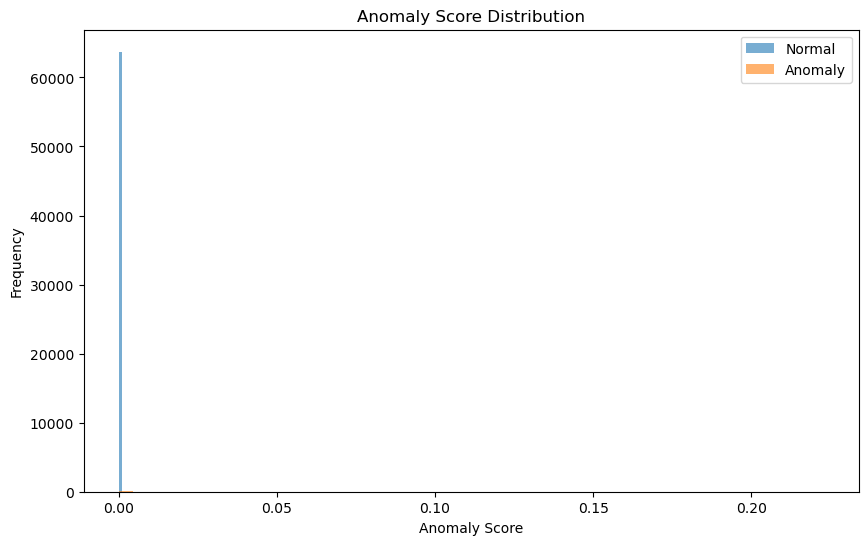

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(train_anomaly_scores[train_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(train_anomaly_scores[train_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


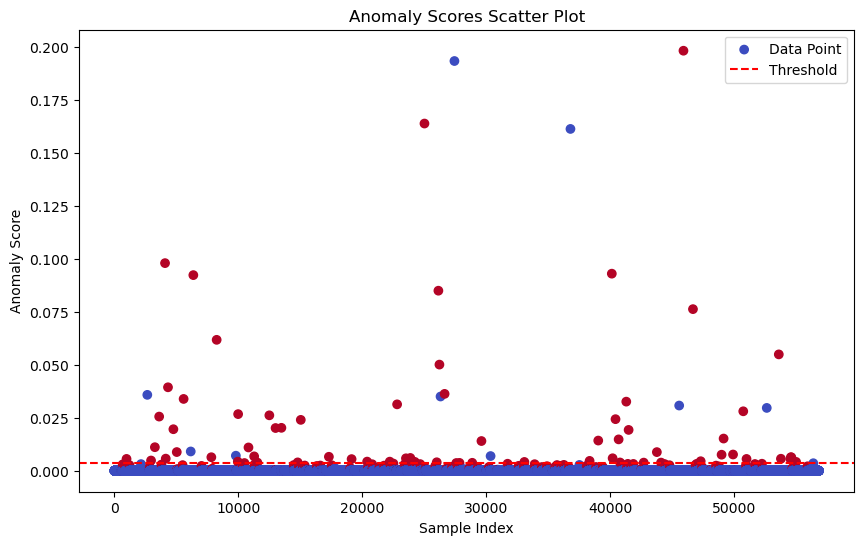

In [41]:
def plot_anomaly_scores_scatter(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=true_labels, cmap='coolwarm', label='Data Point')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores Scatter Plot')
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_scores_scatter(test_anomaly_scores, test_true_labels, threshold)


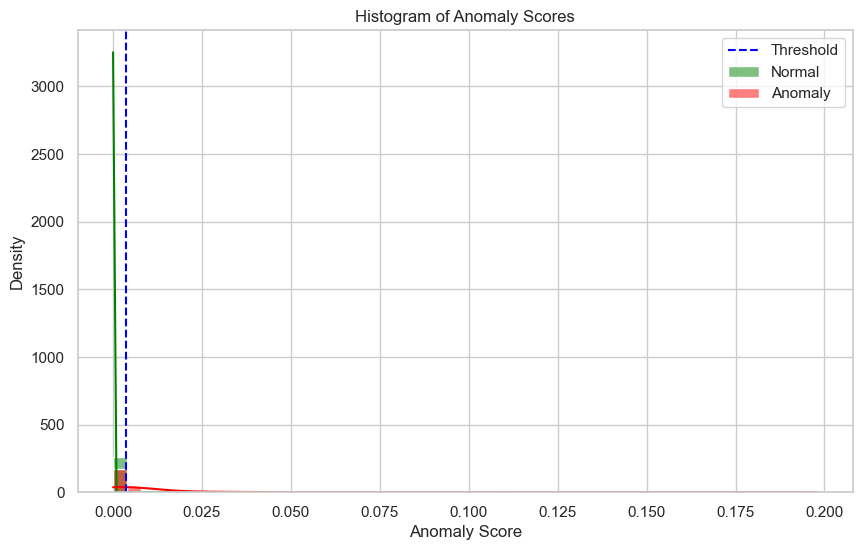

In [42]:


# Set plot style
sns.set(style='whitegrid')
def plot_anomaly_score_histogram(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores[true_labels == 0], bins=50, color='green', label='Normal', kde=True, stat='density')
    sns.histplot(anomaly_scores[true_labels == 1], bins=50, color='red', label='Anomaly', kde=True, stat='density')
    plt.axvline(threshold, color='blue', linestyle='--', label='Threshold')
    plt.title('Histogram of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_score_histogram(test_anomaly_scores, test_true_labels, threshold)


In [43]:


# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_true_labels, test_anomaly_scores)
ap_score = average_precision_score(test_true_labels, test_anomaly_scores)
print(f"Average Precision Score: {ap_score:.4f}")


AUC-ROC Score: 0.9984
Average Precision Score: 0.8293


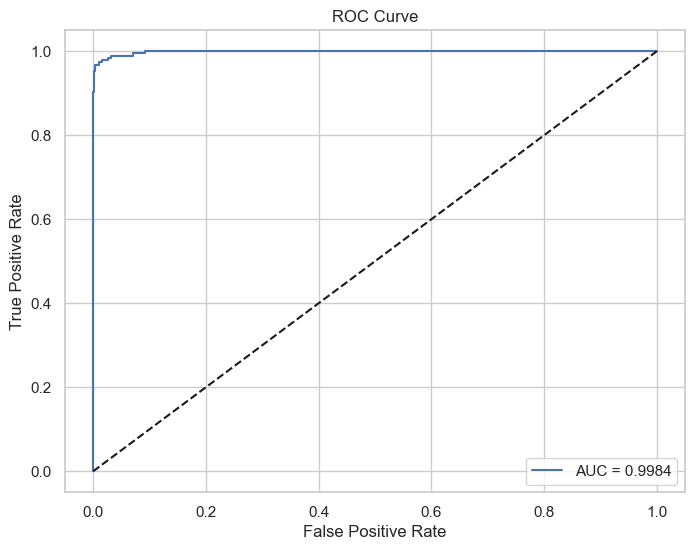

In [44]:
fpr, tpr, thresholds = roc_curve(test_true_labels, test_anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [45]:


# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56650
     Anomaly       0.92      0.77      0.84       187

    accuracy                           1.00     56837
   macro avg       0.96      0.88      0.92     56837
weighted avg       1.00      1.00      1.00     56837

Confusion Matrix:
[[56637    13]
 [   43   144]]
AUC-ROC Score: 0.9984


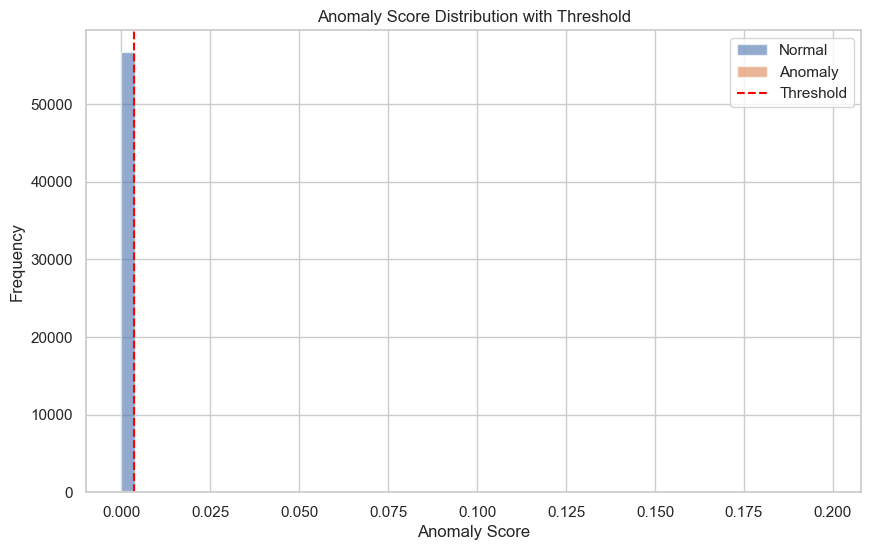

In [46]:


plt.figure(figsize=(10, 6))
plt.hist(test_anomaly_scores[test_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(test_anomaly_scores[test_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution with Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
